In [1]:
# load library

from mmhuman3d.core.conventions.keypoints_mapping import convert_kps
from mmhuman3d.models.body_models.smpl import SMPL
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Function to remove keypoints with NaN values
def remove_nan_keypoints(keypoints_2d):
    # Filter out keypoints that are not NaN
    valid_keypoints = keypoints_2d[~np.isnan(keypoints_2d).any(axis=1)]
    return valid_keypoints

# Function to visualize 2D keypoints
def plot_keypoints_2d(keypoints_2d, image_width=640, image_height=480):
    valid_keypoints = remove_nan_keypoints(keypoints_2d)

    # Adjusting the scale of the coordinates
    max_x, max_y = np.max(valid_keypoints, axis=0)
    min_x, min_y = np.min(valid_keypoints, axis=0)

    # Scaling the coordinates if they are too small
    scale_x = image_width / (max_x - min_x) if max_x - min_x != 0 else 1
    scale_y = image_height / (max_y - min_y) if max_y - min_y != 0 else 1

    # Apply scaling to the coordinates
    valid_keypoints[:, 0] = (valid_keypoints[:, 0] - min_x) * scale_x
    valid_keypoints[:, 1] = (valid_keypoints[:, 1] - min_y) * scale_y

    plt.figure(figsize=(6, 6))
    plt.scatter(valid_keypoints[:, 0], valid_keypoints[:, 1], s=10, c='r', marker='o')

    # Label each keypoint with its index for visual distinction
    for i, (x, y) in enumerate(valid_keypoints):
        plt.text(x, y, str(i), fontsize=8, color='blue')

    # Dynamically set x and y axis limits
    plt.xlim(0, image_width)
    plt.ylim(0, image_height)
    plt.gca().invert_yaxis()  # Invert Y-axis to match image coordinate system
    plt.title("2D Keypoints Visualization")
    plt.show()

In [3]:
# Load SMPL model
### you have to set path smpl model and npy_file_path(data)
smpl_model = SMPL(model_path='C:/Users/SMPL_python_v.1.1.0/smpl/models/basicmodel_neutral_lbs_10_207_0_v1.1.0.pkl', gender='neutral', batch_size=1)

# Example SMPL parameters
betas = torch.zeros([1, 10])  # Shape parameters
body_pose = torch.zeros([1, 69])  # Body pose parameters
global_orient = torch.zeros([1, 3])  # Global orientation
transl = torch.zeros([1, 3])  # Translation

# Generate 3D keypoints using the SMPL model
output = smpl_model(betas=betas, body_pose=body_pose, global_orient=global_orient, transl=transl)

# Extract 3D keypoints from the 'joints' key
keypoints_3d = output['joints']  # Retrieve joints from the SMPL model output

# Select the top 45 keypoints from the generated 190 keypoints (adjust as needed)
keypoints_3d_45 = keypoints_3d[:, :45, :]  # Select the first 45 keypoints

# Project to 2D by dividing by the z-coordinate
keypoints_2d_45 = keypoints_3d_45[:, :, :2] / keypoints_3d_45[:, :, 2:3]

# Check the shape of the 2D keypoints
print(f"2D keypoints shape: {keypoints_2d_45.shape}")  # Expected: (batch_size, 45, 2)

# Convert from SMPL format to COCO format
keypoints_coco = convert_kps(keypoints_2d_45, src='smpl_45', dst='coco')
print(keypoints_coco)

2D keypoints shape: torch.Size([1, 45, 2])
(tensor([[[     nan,      nan],
         [     nan,      nan],
         [     nan,      nan],
         [     nan,      nan],
         [     nan,      nan],
         [-11.5591, -15.1463],
         [  8.8828, -11.4165],
         [-10.1960,  -5.0308],
         [ 10.4305,  -5.1505],
         [-15.6454,  -5.1019],
         [ 14.6576,  -4.7036],
         [  0.0000,   0.0000],
         [  0.0000,   0.0000],
         [  6.0327, -40.8055],
         [ -7.1602, -46.2763],
         [ -3.3005,  40.6154],
         [  3.3739,  40.1591]]]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1], dtype=torch.uint8))


In [4]:
# Load SMPL model
### you have to set path smpl model and npy_file_path(data)

smpl_model = SMPL(model_path='C:/Users/SMPL_python_v.1.1.0/smpl/models/basicmodel_neutral_lbs_10_207_0_v1.1.0.pkl', gender='neutral', batch_size=1)

# Load data from npy file
npy_file_path = 'D:/data/motionx_smplx-001/motion_data/smplx_322/dance/subset_0000/Basic_Dai_DAnce_clip_1.npy'
npy_data = np.load(npy_file_path, allow_pickle=True)

# Extract necessary parameters from the data (explicitly specifying dtype)
betas = torch.tensor(npy_data[0, :10], dtype=torch.float32).unsqueeze(0)  # Shape parameters
body_pose = torch.tensor(npy_data[0, 10:79], dtype=torch.float32).unsqueeze(0)  # Body pose parameters
global_orient = torch.tensor(npy_data[0, 79:82], dtype=torch.float32).unsqueeze(0)  # Global orientation
transl = torch.tensor(npy_data[0, 82:85], dtype=torch.float32).unsqueeze(0)  # Translation

# Generate 3D keypoints using the SMPL model
output = smpl_model(betas=betas, body_pose=body_pose, global_orient=global_orient, transl=transl)


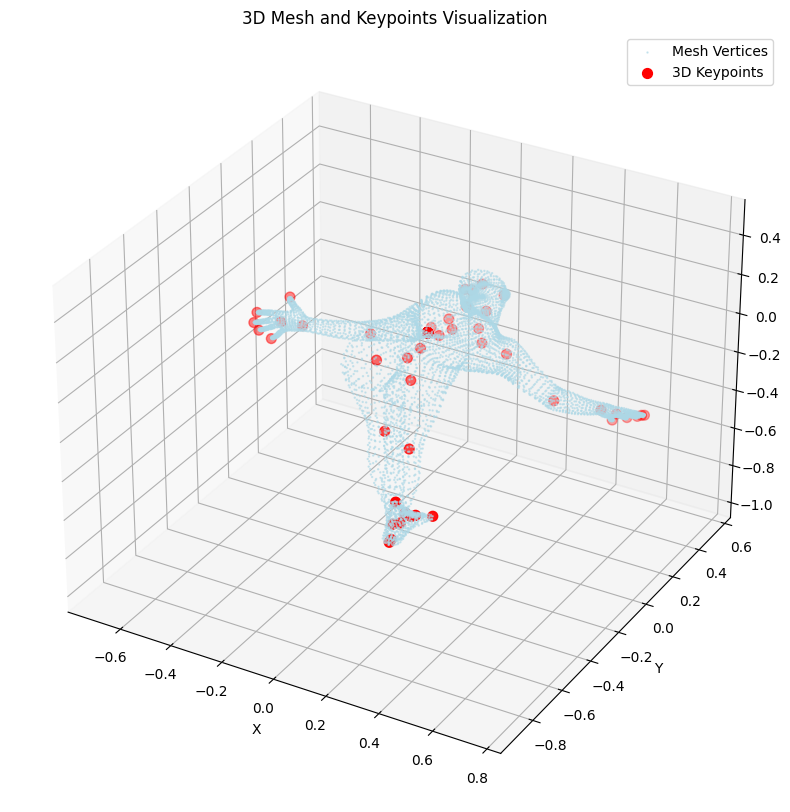

In [5]:
# Get 3D vertices and joints from the SMPL model
vertices = output['vertices'][0].cpu().numpy()  # 3D points of the mesh (vertices)
joints = output['joints'][0].cpu().numpy()  # 3D keypoints (joints)

# Set up the 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D points of the mesh (vertices)
ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], s=0.5, color='lightblue', alpha=0.6, label='Mesh Vertices')

# Plot the 3D keypoints (main body parts) (joints)
ax.scatter(joints[:, 0], joints[:, 1], joints[:, 2], s=50, color='red', label='3D Keypoints')

# Visualization settings
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set min and max values to align the axes for both mesh and keypoints
max_range = np.array([vertices[:, 0].max() - vertices[:, 0].min(),
                      vertices[:, 1].max() - vertices[:, 1].min(),
                      vertices[:, 2].max() - vertices[:, 2].min()]).max() / 2.0

mid_x = (vertices[:, 0].max() + vertices[:, 0].min()) * 0.5
mid_y = (vertices[:, 1].max() + vertices[:, 1].min()) * 0.5
mid_z = (vertices[:, 2].max() + vertices[:, 2].min()) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# Add plot title and legend
ax.set_title("3D Mesh and Keypoints Visualization")
ax.legend()

# Display the visualization
plt.show()


C:\Users\byeol\AppData\Local\Temp\ipykernel_22432\1231473982.py:8: RuntimeWarning: invalid value encountered in divide
  points_2d = points_3d[:, :2] / points_3d[:, 2:3] * focal_length


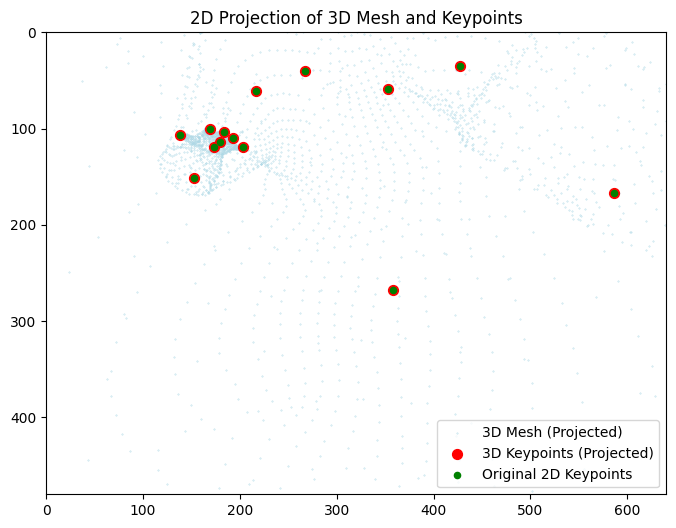

In [20]:
# 가상의 카메라 매트릭스 (초점 거리와 중심점 설정)
focal_length = 150  # 초점 거리 (값을 조정하여 투영된 값이 화면에 잘 보이도록 조절)
image_center = np.array([320, 240])  # 이미지 중앙 좌표 (임의값)

# 카메라 투영 함수 (3D -> 2D)
def project_3d_to_2d(points_3d, focal_length, image_center):
    # z로 나누어 2D로 투영 (초점 거리를 고려하여 확대/축소)
    points_2d = points_3d[:, :2] / points_3d[:, 2:3] * focal_length
    points_2d += image_center  # 이미지의 중앙에 맞춤
    return points_2d

# SMPL 모델로부터 3D vertices와 joints 가져오기
vertices = output['vertices'][0].cpu().numpy()  # 메쉬의 3D 점들 (vertices)
joints = output['joints'][0].cpu().numpy()  # 3D keypoints (joints)

# 3D 메쉬를 2D 평면으로 투영
vertices_2d = project_3d_to_2d(vertices, focal_length, image_center)
joints_2d = project_3d_to_2d(joints, focal_length, image_center)

# 기존의 2D keypoints (이미 계산됨)
keypoints_2d = project_3d_to_2d(joints, focal_length, image_center)

# 시각화 시작
fig, ax = plt.subplots(figsize=(8, 6))

# 2D로 투영된 메쉬 그리기
ax.scatter(vertices_2d[:, 0], vertices_2d[:, 1], s=0.1, color='lightblue', label="3D Mesh (Projected)")

# 2D로 투영된 keypoints 그리기
ax.scatter(joints_2d[:, 0], joints_2d[:, 1], s=50, color='red', label="3D Keypoints (Projected)")

# 기존 2D keypoints 그리기
ax.scatter(keypoints_2d[:, 0], keypoints_2d[:, 1], s=20, color='green', label="Original 2D Keypoints")

# 이미지 축 설정 (범위 조정)
ax.set_xlim(0, 640)  # 가상의 이미지 너비 조정
ax.set_ylim(0, 480)  # 가상의 이미지 높이 조정
ax.invert_yaxis()  # 이미지 축을 반전 (상단이 0)

# 레이블 추가 및 시각화
ax.set_title("2D Projection of 3D Mesh and Keypoints")
ax.legend()
plt.show()